In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import sys
from tqdm import tqdm
import re
sys.path.append('../..')

from config.pmt_data import *

%load_ext autoreload
%autoreload 2

In [2]:
#Constants
PedRangeMax = 14265
PedRangeMin = 14235
PedRangeMed = (PedRangeMax + PedRangeMin)/2

In [3]:
DATA_DIR

'/exp/sbnd/data/users/brindenc/PAD/data/run14445'

In [4]:
tree = uproot.open(DATA_DIR+'/'+HDUMP_NAME)
waveform_names = [k.strip('wvfana/') for k in tree.keys() if 'wvfana' in k and 'wvfana;' not in k]
waveform_names[0]

'event_4583_opchannel_17_pmt_coated_0;1'

In [5]:
event = 4583
ch = 140
key_name = [k for k in tree.keys() if f'opchannel_{ch}_' in k and f'event_{event}_' in k][0]
key_name

'wvfana/event_4583_opchannel_140_pmt_coated_52;1'

In [6]:

ch

140

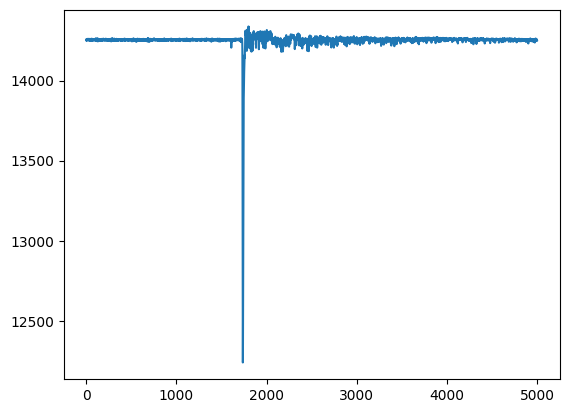

In [7]:
hist = tree[key_name]
hist.axis().edges(),hist.values()
plt.plot(hist.values())

In [8]:
def plot_hist_edges(edges,values,errors,label,ax=None,**pltkwargs):
  """
  Make step plot from edges and values
  
  Parameters
  ----------
  edges : array-like
      Edges of histogram bins
  values : array-like
      Values of histogram bins
  errors : array-like or None
      Errors of histogram bins
  label : str
      Label for legend
  ax : matplotlib.axes.Axes or None
      Axes to plot on. If None, use current axes.
  pltkwargs : dict
      Keyword arguments to pass to matplotlib.pyplot.step()
  
  """
  centers = (edges[1:] + edges[:-1])/2
  if ax is None:
      h = plt.step(edges, list(values)+[values[-1]], where='post', label=label,**pltkwargs)
      if errors is not None: 
          e = plt.errorbar(centers, values, yerr=errors, elinewidth=3,fmt='none', color=h[0].get_color(),alpha=0.6,capsize=7)
      else:
          e = None
  else:
      h = ax.step(edges, list(values)+[values[-1]], where='post', label=label,**pltkwargs)
      if errors is not None: 
          e = ax.errorbar(centers, values, yerr=errors, elinewidth=3,fmt='none', color=h[0].get_color(),alpha=0.6,capsize=7) 
      else:
          e = None
  return h,e

def draw_all_waveforms(tree,event,threshold=None,ped_max=None,ped_min=None,ax=None,fig=None,use_tick=True,show_label_threshold=5,**kwargs):
    """
    
    """
    if threshold is not None:
        assert ped_min is not None and threshold is not None, 'Must provide ped_min,ped_max if threshlod is provided'
    #Get all key names
    keys = [k for k in tree.keys() if f'event_{event}_' in k]
    assert len(keys) > 0, f'No keys found for event {event}'
    
    pattern = r'opchannel_(\d+)'
    
    
    #Initialize histograms
    ts = [None]*len(keys)
    wave = [None]*len(keys)
    thresholds = [None]*len(keys)
    chs = [int(re.findall(pattern,k)[0]) for k in keys]
    for i,k in enumerate(keys):
        hist = tree[k]
        times = hist.axis().edges()
        ticks = np.linspace(0,len(times)-1,len(times)-1)
        time_centers = (times[1:] + times[:-1])/2
        assert len(time_centers) == len(ticks), f'Time ({len(time_centers)}) and tick ({len(ticks)}) arrays are not the same length'
        ts[i] = times
        wave[i] = hist.values()
        #Find all t and wave combo where wave > threshold
        if threshold is not None: 
            hits = (wave[i] > threshold + ped_max) | (wave[i] < ped_min - threshold)
            if use_tick:
                thresholds[i] = [wave[i][hits],ticks[hits]]
            else:
                thresholds[i] = [wave[i][hits],time_centers[hits]]
    print(f'dt = {ts[0][1] - ts[0][0]}')
    print(f't_max = {ts[0][-1]} t_min = {ts[0][0]}')
            
    
    #Plot
    if fig is None and ax is None:
        fig,ax = plt.subplots(figsize=(10,5))
    for i,(t,w,thresh) in tqdm(enumerate(zip(ts,wave,thresholds))):
        #print(f'{label} : has crossed threshold {len(thresh[0])} times')
        if len(thresh[0]) > show_label_threshold:
            label = f'PDS {chs[i]}'
            #label = f'{label} ({len(thresh[0])})'
        else:
            label = None
        if use_tick:
            ax.plot(wave,**kwargs)
        else:
            plot_hist_edges(t,w,None,label,ax=ax,**kwargs)
            
        if threshold is not None:
            ax.scatter(thresh[1],thresh[0],s=2)
        
    if use_tick:
        ax.set_xlabel('Tick')
    else:
        ax.set_xlabel('Time [us]')
    ax.set_ylabel('ADC')
    ax.set_title(f'{DATA_DIR} (Event {event})')
    return fig,ax
        
    

dt = 0.0019999999999527063
t_max = -2125.0 t_min = -2135.0


120it [00:00, 417.87it/s]


(-2130.0, -2125.0)

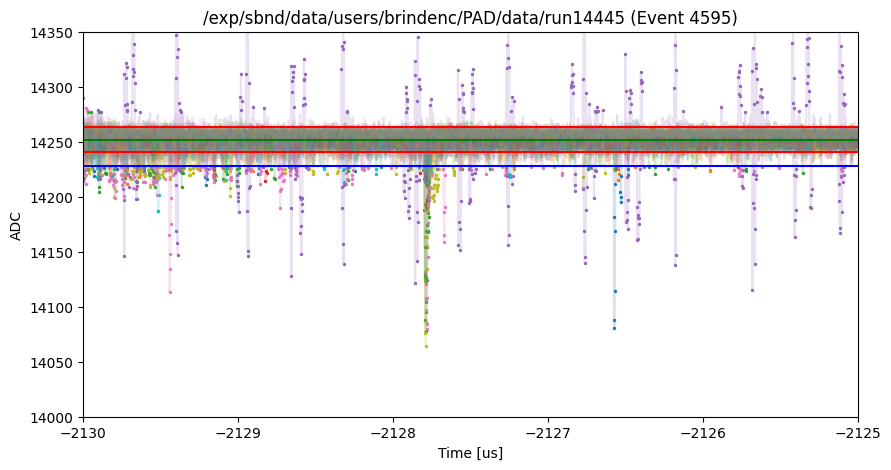

In [10]:
#Constants
PedRangeMax = 14263
PedRangeMin = 14241
PedRangeMed = (PedRangeMax + PedRangeMin)/2
threshold = 13
event = 4595

#Plot
fig,ax = draw_all_waveforms(tree,event,threshold=threshold,ped_max=PedRangeMax,ped_min=PedRangeMin,use_tick=False
                            ,alpha=0.2)
#ax.set_xlim([-2125,-2100])
#ax.set_ylim([14000,14350])
#ax.set_ylim([PedRangeMin-10,PedRangeMin+1])
ax.axhline(PedRangeMin, label='PedRangeMin/Max',color='r')
ax.axhline(PedRangeMax, color='r')
ax.axhline(PedRangeMed, label='PedRangeMed',color='g')
ax.axhline(PedRangeMin-threshold, label='PedRangeMin - threshold',color='b')
#ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
#ax.set_xlim([-2131.25,-2130])
ax.set_xlim([-2130,-2125])

In [44]:
hd = tree['hitdumper/hitdumpertree;1']
op_keys = [k for k in hd.keys() if k[:5] == 'ophit']
op_keys
df = hd.arrays(op_keys,library='pd')

/exp/sbnd/app/users/brindenc/env_al9/lib64/python3.9/site-packages/uproot/interpretation/library.py:753: FutureWarning: MultiIndex.is_integer is deprecated. Use pandas.api.types.is_integer_dtype instead.
  if hasattr(index, "is_integer") and index.is_integer():


In [51]:
mmin = 9e99
mmax = -9e99
tshift = 2135
for t in df.ophit_peakT+tshift:
    if np.min(t) < mmin:
        mmin = np.min(t)
    if np.max(t) > mmax:
        mmax = np.max(t)
print(mmax,mmin)

18.994000000000142 0.0019999999999527063


In [33]:
df

ophit_opch  ophit_opdet  ophit_peakT  ophit_startT  \
entry subentry                                                       
0     0                 17           17    -2119.382     -2119.394   
      1                 17           17    -2119.132     -2119.142   
      2                 17           17    -2118.870     -2118.880   
      3                 17           17    -2118.650     -2118.660   
      4                 17           17    -2118.492     -2118.504   
...                    ...          ...          ...           ...   
14    3340             244          244    -2116.382     -2116.394   
      3341             244          244    -2116.322     -2116.332   
      3342             244          244    -2116.296     -2116.308   
      3343             244          244    -2116.226     -2116.236   
      3344             244          244    -2116.116     -2116.128   

                ophit_riseT  ophit_width  ophit_area  ophit_amplitude  \
entry subentry                                                          
0     0              -0.002        0.040  160.185345        26.682777   
      1              -0.002        0.038  108.300746        14.945868   
      2              -0.002        0.038   75.078993        14.212252   
      3              -0.002        0.034   55.656557        17.886148   
      4              -0.002        0.036   84.129672        20.588279   
...                     ...          ...         ...              ...   
14    3340           -0.002        0.046  125.022580        34.748387   
      3341           -0.002        0.022   49.316129        14.458065   
      3342           -0.002        0.040   58.335484        20.332258   
      3343           -0.002        0.036   61.940968        20.023831   
      3344           -0.002        0.036   93.100000        28.950000   

                ophit_pe  ophit_opdet_x  ophit_opdet_y  ophit_opdet_z  \
entry subentry                                                          
0     0         2.414976          213.4          175.0      27.874225   
      1         1.632757          213.4          175.0      27.874225   
      2         1.131901          213.4          175.0      27.874225   
      3         0.839086          213.4          175.0      27.874225   
      4         1.268350          213.4          175.0      27.874225   
...                  ...            ...            ...            ...   
14    3340      1.884857         -213.4          -40.0     421.525775   
      3341      0.743497         -213.4          -40.0     421.525775   
      3342      0.879474         -213.4          -40.0     421.525775   
      3343      0.933830         -213.4          -40.0     421.525775   
      3344      1.403588         -213.4          -40.0     421.525775   

                ophit_opdet_type  
entry subentry                    
0     0                        0  
      1                        0  
      2                        0  
      3                        0  
      4                        0  
...                          ...  
14    3340                     0  
      3341                     0  
      3342                     0  
      3343                     0  
      3344                     0  

[27449 rows x 13 columns]

In [14]:
df

ophit_opch  ophit_opdet  ophit_peakT  ophit_startT  \
entry subentry                                                       
0     0                 17           17    -2119.382     -2119.394   
      1                 17           17    -2119.132     -2119.142   
      2                 17           17    -2118.870     -2118.880   
      3                 17           17    -2118.650     -2118.660   
      4                 17           17    -2118.492     -2118.504   
...                    ...          ...          ...           ...   
14    3340             244          244    -2116.382     -2116.394   
      3341             244          244    -2116.322     -2116.332   
      3342             244          244    -2116.296     -2116.308   
      3343             244          244    -2116.226     -2116.236   
      3344             244          244    -2116.116     -2116.128   

                ophit_riseT  ophit_width  ophit_area  ophit_amplitude  \
entry subentry                                                          
0     0              -0.002        0.040  160.185345        26.682777   
      1              -0.002        0.038  108.300746        14.945868   
      2              -0.002        0.038   75.078993        14.212252   
      3              -0.002        0.034   55.656557        17.886148   
      4              -0.002        0.036   84.129672        20.588279   
...                     ...          ...         ...              ...   
14    3340           -0.002        0.046  125.022580        34.748387   
      3341           -0.002        0.022   49.316129        14.458065   
      3342           -0.002        0.040   58.335484        20.332258   
      3343           -0.002        0.036   61.940968        20.023831   
      3344           -0.002        0.036   93.100000        28.950000   

                ophit_pe  ophit_opdet_x  ophit_opdet_y  ophit_opdet_z  \
entry subentry                                                          
0     0         2.414976          213.4          175.0      27.874225   
      1         1.632757          213.4          175.0      27.874225   
      2         1.131901          213.4          175.0      27.874225   
      3         0.839086          213.4          175.0      27.874225   
      4         1.268350          213.4          175.0      27.874225   
...                  ...            ...            ...            ...   
14    3340      1.884857         -213.4          -40.0     421.525775   
      3341      0.743497         -213.4          -40.0     421.525775   
      3342      0.879474         -213.4          -40.0     421.525775   
      3343      0.933830         -213.4          -40.0     421.525775   
      3344      1.403588         -213.4          -40.0     421.525775   

                ophit_opdet_type  
entry subentry                    
0     0                        0  
      1                        0  
      2                        0  
      3                        0  
      4                        0  
...                          ...  
14    3340                     0  
      3341                     0  
      3342                     0  
      3343                     0  
      3344                     0  

[27449 rows x 13 columns]

Text(0, 0.5, 'PE')

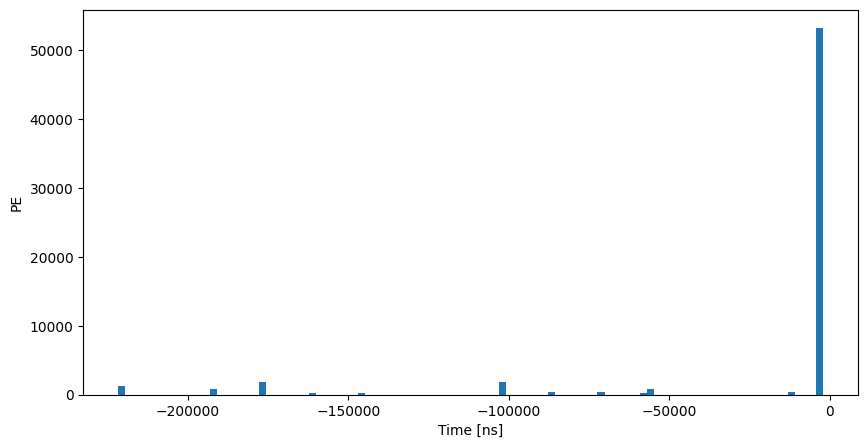

In [29]:
#Plot hit times weighted by PE
tshift = 0
fig,ax = plt.subplots(figsize=(10,5))
ax.hist(df.ophit_peakT+tshift
        #,bins=np.arange(-2150+tshift,-2100+tshift,1)
        ,bins=100
        ,weights=df.ophit_pe)
ax.set_xlabel('Time [ns]')
ax.set_ylabel('PE')